In [2]:
using MLDatasets
using Statistics
using PyPlot
using Distributions
using ProgressMeter
using Random

In [145]:
train_size =5900*2*0.9
lambda =0.01
epsilon = 3000

# rand(Gamma(784,2*784/(epsilon*train_size*lambda)),1)

1-element Array{Float64,1}:
 3.941989538608417

In [3]:
# load full training set
train_x, train_y = MNIST.traindata()

# load full test set
test_x,  test_y  = MNIST.testdata()

xtrain0 = zeros(784,12000)
xtrain1 = zeros(784,12000)
xlabel =zeros(12000)
global counter0=0
global counter1=0
for i=1:size(train_x,3)
    if train_y[i]==7
        global counter0=counter0+1
        xtrain0[:,counter0]=vec(1.0*train_x[:,:,i])
    end
    if train_y[i]==9
        global counter1=counter1+1
        xtrain1[:,counter1]=vec(1.0*train_x[:,:,i])
    end            
end

xtest0 = zeros(784,12000)
xtest1 = zeros(784,12000)
xtestlabel =zeros(12000)
global counter0=0
global counter1=0
for i=1:size(test_x,3)
    if test_y[i]==7
        global counter0=counter0+1
        xtest0[:,counter0]=vec(1.0*test_x[:,:,i])
    end
    if test_y[i]==9
        global counter1=counter1+1
        xtest1[:,counter1]=vec(1.0*test_x[:,:,i])
    end            
end

Ntrain=9000; Ntest=1800

x=[xtrain0[:,1:Int(Ntrain/2)] xtrain1[:,1:Int(Ntrain/2)]]
c=ones(Int,Ntrain)
for i=1:Int(Ntrain/2)
    c[i]=0
end

xtest=[xtest0[:,1:Int(Ntest/2)] xtest1[:,1:Int(Ntest/2)]]
ctest=ones(Int,Ntest)
for i=1:Int(Ntest/2)
    ctest[i]=0
end

In [4]:
function plot_image(x)
    xx=reshape(x,28,28)
    xxx=zeros(28,28)
    for i=1:28
        for j=1:28
            xxx[29-i,j]=xx[j,i]
        end
    end
    pcolormesh(xxx,cmap="gray")
    axis("equal")
    gca()[:set_axis_off]()
end

function prob_cgtc(tc)
    qcgtc = zeros(2,1)
    if tc==0
        qcgtc[1] = p0g0
        qcgtc[2] = p0g1
    else
        qcgtc[1] = p1g0
        qcgtc[2] = p1g1
    end
    qcgtc=qcgtc./sum(qcgtc)
end

function prob_xgtx(tx)
    mean_xgtx = zeros(length(tx),1)
    var_xgtx = zeros(length(tx),1)
    for i=1:length(tx)
        a = 1/spread_var[i] + 1/prior_var[i]
        b = tx[i]/spread_var[i] + prior_mean[i]/prior_var[i]
        mean_xgtx[i]=b/a
        var_xgtx[i]=1/a        
    end
    return (mean_xgtx,var_xgtx)
end

function prob_xgtx!(tx)
    for i=1:length(tx)
        a = 1/spread_var[i] + 1/prior_var[i]
        b = tx[i]/spread_var[i] + prior_mean[i]/prior_var[i]
        mean_xgtx[i]=b/a
        var_xgtx[i]=1/a        
    end
#    return (mean_xgtx,var_xgtx)    
end

function prob_xgtx_binomial(tx,b,m,epsilon)
    sigma = m/(b^2*epsilon)
    theta = 0.11940392323596105
    thetaB = zeros(length(tx))
    for i=1:length(tx)
        A = exp(-abs(tx[i]-1)/sigma)*theta
        B = exp(-abs(tx[i])/sigma)*(1-theta)
        thetaB[i] = A/(A+B)
    end    
    return thetaB
end

sigmoid(x) = 1.0 ./ (1.0 .+exp.(-x))

function grad_theta(theta,c,x)
    g=zeros(size(x))
    cbar=2*c-1
    g = cbar*(1-sigmoid(cbar.*sum(theta.*x))).*x
end

function loglik(b,theta,c,x,bounds=true)
    L=0.0
    for n=1:size(x,2)
        if b == 1
            L = L+log(sigmoid( (2*c[n]-1).*sum(theta.*x[:,n])))    
        else
            L = L+log(sigmoid( (2*c[n]-1).*sum(theta.*pixelization(x[:,n],b,0,1,bounds)[2])))
        end
    end
    return L
end

function truncate(tx)
    x_truncated=zeros(length(tx))
    for i=1:length(tx)
        x_truncated[i] = tx[i]
        if tx[i] > 1
            x_truncated[i] = 1
        end
        if tx[i] < 0
            x_truncated[i] = 0
        end
    end
    return x_truncated
end

function MSE(image1,image2)
    if length(image1)!=length(image2)
        println("Error: two images need to have same number of pixels!")
    end
    MSE=0
    for i=1:length(image1)
        MSE+=(image1[i]-image2[i])^2
    end
    return MSE/length(image1)
end

function ME(image1,image2)
    if length(image1)!=length(image2)
        println("Error: two images need to have same number of pixels!")
    end
    ME=0
    for i=1:length(image1)
        ME+=abs(image1[i]-image2[i])
    end
    return ME/length(image1)
end
# function label_flip(c,p0g0,p1g1)
#     ctilde=zeros(Int,size(c))
#     for n=1:size(c)[1]
#         if c[n]==0
#             if rand()<p0g0
#                 ctilde[n]=0
#             else
#                 ctilde[n]=1
#             end
#         end
#         if c[n]==1
#             if rand()<p1g1
#                 ctilde[n]=1
#             else
#                 ctilde[n]=0
#             end
#         end
#     end
#     return ctilde
# end

ME (generic function with 1 method)

In [4]:
#pixelization
#b=1,2,4,7,14
function pixelization(x,b,m,epsilon,bounds=true)
    d = convert(Int64,28/b)
    Pb = zeros(d,d)
    x_tilde = zeros(784)
    x_pixel = zeros(convert(Int64,784/b^2))
    for i=1:d
        for j=1:d
            for k=1:b^2
                l = 1+(k-1)÷b*28+(k-1)%b+(j-1)*b+(i-1)*28*b
                Pb[i,j]+=x[l]/(b^2)
            end
            #add scaled laplace distribution with truncation
            if m != 0
                if rand()<0.5
                    Pb[i,j]+=m/(b^2*epsilon)*randexp()
                else
                    Pb[i,j]-=m/(b^2*epsilon)*randexp()
                end
                if bounds
                    Pb[i,j]=max(0,Pb[i,j])
                    Pb[i,j]=min(1,Pb[i,j])
                end            
            end
            for k=1:b^2
                l = 1+(k-1)÷b*28+(k-1)%b+(j-1)*b+(i-1)*28*b
                x_tilde[l]=Pb[i,j]
            end
            x_pixel[convert(Int64,j+(i-1)*d)]=Pb[i,j]
        end
    end
    return (x_tilde,x_pixel)    
end

pixelization (generic function with 2 methods)

In [5]:
p0g0=0.8; p1g0=1-p0g0
p1g1=0.8; p0g1=1-p1g1

# SPREAD DIVERGENCE

#prior_mean=mean(x,dims=2)
#prior_var=std(x,dims=2)
#spread_std=std(x,dims=2) .+ 0.01
#spread_var=spread_std.^2

# generate the noisy training data
function spread_divergence(c,x,b,m,epsilon,bounds=true)
    ctilde=zeros(Int,size(c))
    xtilde=zeros(size(x))
    x_pixel=zeros(convert(Int64,784/b^2),size(x)[2])
    for n=1:size(x)[2]
        if c[n]==0
            if rand()<p0g0
                ctilde[n]=0
            else
                ctilde[n]=1
            end
        end
        if c[n]==1
            if rand()<p1g1
                ctilde[n]=1
            else
                ctilde[n]=0
            end
        end
        (xtilde[:,n],x_pixel[:,n])=pixelization(x[:,n],b,m,epsilon,bounds)
    end
    return (ctilde, xtilde, x_pixel)
end

spread_divergence (generic function with 2 methods)

# Some statistics of MNIST dataset

## 7and9

In [102]:
x_concat = reshape(x,9000*728)

DimensionMismatch: DimensionMismatch("parent has 47040000 elements, which is incompatible with size (35280000,)")

In [1]:
counter = 0
for n=1:7056000
    if x_concat[n]<0.8
        if x_concat[n]>0.2
            counter += 1
        end
    end
end
counter/7056000

UndefVarError: UndefVarError: x_concat not defined

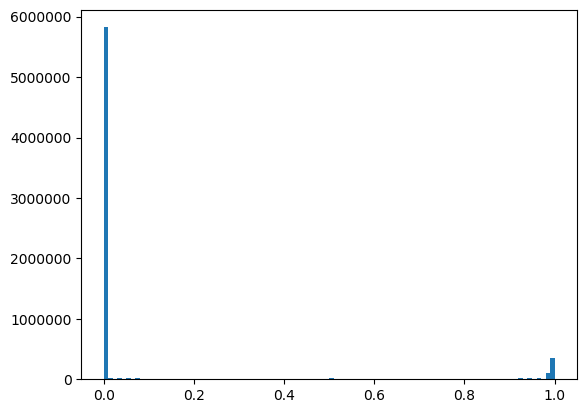

([5.8237e6, 15637.0, 10828.0, 14688.0, 9051.0, 13598.0, 7632.0, 13030.0, 8768.0, 11321.0  …  11886.0, 10093.0, 12951.0, 7443.0, 14001.0, 10637.0, 15056.0, 10826.0, 106492.0, 360028.0], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x0000000229D11198>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229D11828>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229D2DE10>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229D538D0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229D6E208>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229D7CAC8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229D7C748>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229D89128>, PyObject <matplotlib.patches.Rectangle object at 0x0000000229DA6EF0>, PyObject <matplotlib.patches.Rectangle object 

In [22]:
nbins = 100
h = plt.hist(x_concat,nbins)

In [23]:
mu = mean(x_concat)
println(mu)

0.11940392323596105


approximate this to be Binomial distribution, prob(1) = 0.119, prob(0) = 0.881

In [59]:
sigma2 = var(x_concat)
println(sigma2)

0.08778888427126882


In [61]:
alpha = ((1-mu)/sigma2-1/mu)*mu^2
beta = alpha*(1/mu-1)
println("alpha = ",alpha," ,beta = ",beta)

alpha = 0.023608712197909328 ,beta = 0.17411269894244977


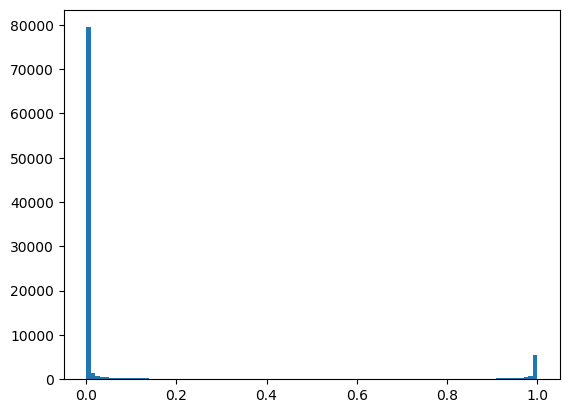

([79427.0, 1349.0, 780.0, 564.0, 438.0, 360.0, 336.0, 278.0, 254.0, 226.0  …  167.0, 190.0, 208.0, 234.0, 238.0, 283.0, 356.0, 468.0, 714.0, 5374.0], [2.39465e-193, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x00000002321424A8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000232126550>, PyObject <matplotlib.patches.Rectangle object at 0x000000023214F400>, PyObject <matplotlib.patches.Rectangle object at 0x000000023215D978>, PyObject <matplotlib.patches.Rectangle object at 0x000000023215D780>, PyObject <matplotlib.patches.Rectangle object at 0x000000023216C0F0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000232177908>, PyObject <matplotlib.patches.Rectangle object at 0x00000002321779B0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000232185860>, PyObject <matplotlib.patches.Rectangle object at 0x00000002321931D0>  … 

In [132]:
samples = 100000
dummy = zeros(samples)
for n=1:samples
    dummy[n]=rand(Beta(alpha, beta))
end
h = plt.hist(dummy,nbins)

In [63]:
var(dummy)

0.08765651335510295

In [134]:
counter = 0
for n=1:samples
    if dummy[n]<0.6
        if dummy[n]>0.4
            counter += 1
        end
    end
end
counter/samples

0.01479

## all digits

In [104]:
x_all = zeros(784,size(train_x,3))
for i=1:size(train_x,3)
    x_all[:,i]=vec(1.0*train_x[:,:,i])
end

In [108]:
x_all_concat = reshape(x_all,10*6000*784)

47040000-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

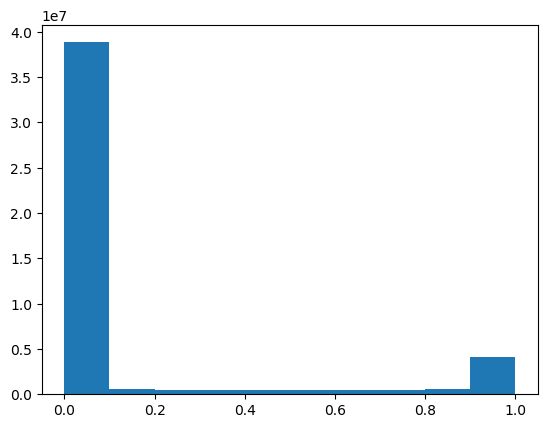

([3.88479e7, 571880.0, 514157.0, 438029.0, 446644.0, 518761.0, 454060.0, 518723.0, 611860.0, 4.11803e6], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x0000000004FA27F0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FA25C0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FA2D68>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FB30B8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FB33C8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FB36D8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FB39E8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FB3CF8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FB3FD0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000004FAC358>])

In [114]:
nbins = 10
h = plt.hist(x_all_concat,nbins)

In [113]:
counter = 0
for n=1:7056000
    if x_all_concat[n]<1.1
        if x_all_concat[n]>-0.1
            counter += 1
        end
    end
end
counter/7056000

1.0

In [116]:
mu = mean(x_all_concat)
println(mu)

0.1306604762738429


# Standard Logistic Regression


## no flip, no Laplace noise, no pixelization

Standard training100%|██████████████████████████████████| Time: 0:01:11


train accuracy = 0.959
test accuracy = 0.9605555555555556
[-5335.27, -4701.75, -4241.76, -3895.06, -3625.35, -3409.75, -3233.52, -3086.6, -2962.1, -2855.11, -2762.08, -2680.34, -2607.9, -2543.2, -2485.0, -2432.34, -2384.42, -2340.6, -2300.34, -2263.22, -2228.85, -2196.92, -2167.17, -2139.37, -2113.31, -2088.84, -2065.8, -2044.06, -2023.5, -2004.03, -1985.55, -1967.99, -1951.27, -1935.33, -1920.11, -1905.56, -1891.64, -1878.29, -1865.49, -1853.2, -1841.38, -1830.0, -1819.04, -1808.48, -1798.29, -1788.45, -1778.94, -1769.74, -1760.84, -1752.22, -1743.86, -1735.76, -1727.9, -1720.26, -1712.85, -1705.64, -1698.64, -1691.82, -1685.18, -1678.72, -1672.42, -1666.28, -1660.3, -1654.46, -1648.76, -1643.19, -1637.76, -1632.45, -1627.26, -1622.18, -1617.22, -1612.36, -1607.61, -1602.96, -1598.4, -1593.93, -1589.56, -1585.27, -1581.07, -1576.95, -1572.91, -1568.94, -1565.05, -1561.23, -1557.48, -1553.79, -1550.18, -1546.62, -1543.13, -1539.69, -1536.32, -1533.0, -1529.74, -1526.52, -1523.37, -1520

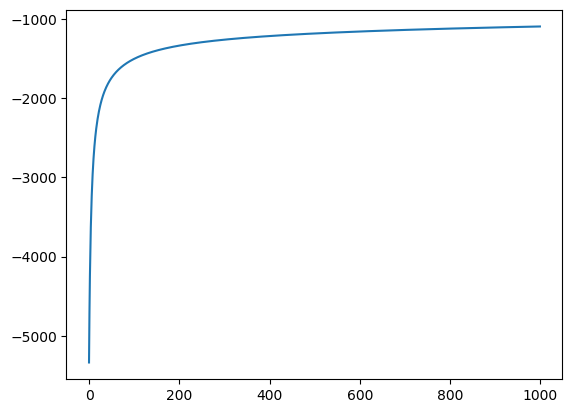

28]

In [8]:
# Do Standard Logistic Regresssion

global theta=zeros(784)
learning_rate=0.2
Nloops=1000
LL=zeros(Nloops)

@showprogress 1 "Standard training"  for loop=1:Nloops 
    grad=zeros(784)
    for n=1:Ntrain
        grad=grad + grad_theta(theta,c[n],x[:,n])
    end
    global theta = theta+learning_rate*grad/Ntrain
    LL[loop]=loglik(1,theta,c,x)
end

plot(LL)

# check training data accuracy

cpred=zeros(Int,Ntrain)
for n=1:Ntrain
    if sigmoid(sum(theta.*x[:,n])) >0.5
        cpred[n]=1
    end    
end

train_accuracy = mean(cpred.==c)
println("train accuracy = $(train_accuracy)")

ctestpred=zeros(Int,Ntest)
for n=1:Ntest
    if sigmoid(sum(theta.*xtest[:,n])) >0.5
        ctestpred[n]=1
    end    
end

test_accuracy = mean(ctestpred.==ctest)
println("test accuracy = $(test_accuracy)")

print(LL)



## flip=0.2, no Laplace noise, no pixelization

Standard training100%|██████████████████████████████████| Time: 0:01:19


flip accuracy = 0.778
train accuracy = 0.9498888888888889
test accuracy = 0.9533333333333334
[-5895.44, -5656.91, -5487.48, -5364.25, -5272.62, -5203.06, -5149.39, -5107.34, -5073.99, -5047.2, -5025.43, -5007.51, -4992.59, -4980.04, -4969.35, -4960.17, -4952.19, -4945.21, -4939.03, -4933.53, -4928.59, -4924.11, -4920.04, -4916.3, -4912.85, -4909.65, -4906.66, -4903.87, -4901.23, -4898.74, -4896.38, -4894.14, -4891.99, -4889.94, -4887.98, -4886.09, -4884.26, -4882.51, -4880.81, -4879.17, -4877.58, -4876.03, -4874.53, -4873.07, -4871.65, -4870.27, -4868.93, -4867.61, -4866.33, -4865.08, -4863.86, -4862.66, -4861.49, -4860.35, -4859.23, -4858.13, -4857.06, -4856.01, -4854.98, -4853.96, -4852.97, -4852.0, -4851.04, -4850.1, -4849.18, -4848.28, -4847.39, -4846.52, -4845.66, -4844.81, -4843.98, -4843.16, -4842.36, -4841.57, -4840.79, -4840.02, -4839.27, -4838.53, -4837.79, -4837.07, -4836.36, -4835.66, -4834.97, -4834.29, -4833.62, -4832.96, -4832.3, -4831.66, -4831.02, -4830.4, -4829.78, -4

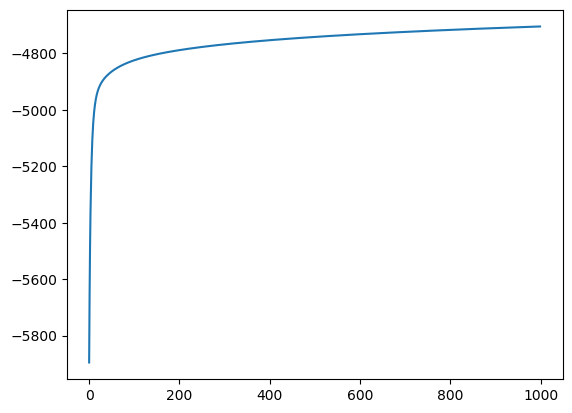

.23, -4705.18, -4705.12, -4705.07, -4705.01, -4704.96, -4704.9, -4704.85, -4704.79, -4704.74, -4704.68, -4704.63, -4704.57, -4704.52, -4704.46, -4704.41, -4704.35, -4704.3, -4704.24]

In [48]:
# Do Standard Logistic Regresssion

global theta=zeros(784)
learning_rate=0.2
Nloops=1000
LL=zeros(Nloops)
# ctilde=zeros(Int,size(c))
(ctilde, xtilde, x_pixel)=spread_divergence(c,x,1,0,1,true)

@showprogress 1 "Standard training"  for loop=1:Nloops 
    grad=zeros(784)
    for n=1:Ntrain
        grad=grad + grad_theta(theta,ctilde[n],x[:,n])
    end
    global theta = theta+learning_rate*grad/Ntrain
    LL[loop]=loglik(1,theta,ctilde,x)
end

plot(LL)

# check training data accuracy

cpred=zeros(Int,Ntrain)
for n=1:Ntrain
    if sigmoid(sum(theta.*x[:,n])) >0.5
        cpred[n]=1
    end    
end

flip_accuracy = mean(cpred.==ctilde)
println("accuracy on noised training set= $(flip_accuracy)")

train_accuracy = mean(cpred.==c)
println("accuracy on denoised training set = $(train_accuracy)")

ctestpred=zeros(Int,Ntest)
for n=1:Ntest
    if sigmoid(sum(theta.*xtest[:,n])) >0.5
        ctestpred[n]=1
    end    
end

test_accuracy = mean(ctestpred.==ctest)
println("test accuracy = $(test_accuracy)")

print(LL)

## flip=0.2, Laplace noise, no pixelization

In Spread Divergence paper, for S=2 importance sampling, Gaussian noise variance = 0.1, test accuracy is 0.944
Here, with standard logistic regression, 

We have two choices, whether place [0,1] bounds on noised image: m=4,b=1 for all following cases

With [0,1] bounds, 

e = 10, with low Laplace noise variance = 2*(m/b^2*eplison)^2=2*(4/10)^2=0.32, test accuracy is 0.946: higher noise variance, simpler method, yet slightli higher test accuracy. It makes the proposed method in original paper not very useful. I will try to improve the Bayesian method to beat this benchmark.
e = 3, test accuracy = 0.931
e = 2, test accuracy = 0.924
e = 1, even with high Laplace noise variance = 2*(m/b^2*eplison)^2=2*(4)^2=32, test accuracy is still as high as 0.898
e = 0.5, test accuracy = 0.802

Without [0,1] bounds, 

e = 1, regression fail to learn on noise variance = 32 (test accuracy = 0.5)
e = 2, test accuracy = 0.53
e = 3,test accuracy = 0.929
e = 10,noise variance = 0.32, test accuracy = 0.943

Standard training100%|██████████████████████████████████| Time: 0:01:04


accuracy on noised training set = 0.5311111111111111
train accuracy = 0.8025555555555556
test accuracy = 0.8022222222222222
[-6236.34, -6686.89, -22325.7, -56699.6, -24212.7, -55119.3, -25727.1, -53749.7, -27037.2, -52512.8, -28218.4, -51366.3, -29311.5, -50284.6, -30341.3, -49251.2, -31323.8, -48254.7, -32270.1, -47287.2, -33188.0, -46342.6, -34083.2, -45416.8, -34959.8, -44506.4, -35821.1, -43609.0, -36669.4, -42722.8, -37506.3, -41846.5, -38333.1, -40979.1, -39150.6, -40120.1, -39959.3, -39269.2, -40759.2, -38426.6, -41550.2, -37592.4, -42331.8, -36767.4, -43103.3, -35952.2, -43863.6, -35148.2, -44611.4, -34356.6, -45345.1, -33579.3, -46062.7, -32818.1, -46761.9, -32075.6, -47440.2, -31354.1, -48094.8, -30656.7, -48722.7, -29986.4, -49320.9, -29346.2, -49886.2, -28739.4, -50415.7, -28169.0, -50906.6, -27637.6, -51356.8, -27147.4, -51764.7, -26700.0, -52129.3, -26296.2, -52450.8, -25936.1, -52729.9, -25618.7, -52968.2, -25342.5, -53167.9, -25105.0, -53331.8, -24903.5, -53463.2, -2473

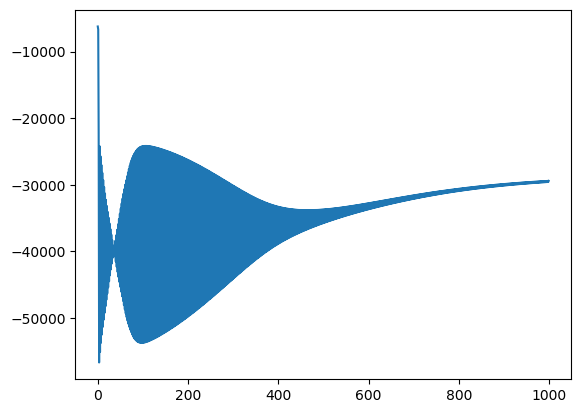

8, -29851.8, -29645.1, -29840.8, -29635.5, -29829.9, -29626.0, -29819.2, -29616.5, -29808.5, -29607.2, -29797.9, -29597.9, -29787.4, -29588.7, -29777.0, -29579.5, -29766.6, -29570.5, -29756.4, -29561.5, -29746.2, -29552.6, -29736.1, -29543.7, -29726.2, -29535.0, -29716.2, -29526.3, -29706.4, -29517.7, -29696.7, -29509.1, -29687.0, -29500.7, -29677.4, -29492.3, -29667.9, -29483.9, -29658.5, -29475.7, -29649.2, -29467.5, -29639.9, -29459.3, -29630.7, -29451.3, -29621.6, -29443.3, -29612.6, -29435.4, -29603.6, -29427.5, -29594.7, -29419.7]

In [122]:
# Do Standard Logistic Regresssion

global theta=zeros(784)
learning_rate=0.2
Nloops=1000
LL=zeros(Nloops)
b=1
(ctilde, xtilde, x_pixel)=spread_divergence(c,x,b,4,0.5,true)



@showprogress 1 "Standard training"  for loop=1:Nloops 
    grad=zeros(784)
    for n=1:Ntrain
        grad=grad + grad_theta(theta,ctilde[n],xtilde[:,n])
    end
    global theta = theta+learning_rate*grad/Ntrain
    LL[loop]=loglik(b,theta,ctilde,xtilde)
end

plot(LL)

# check training data accuracy

cpred=zeros(Int,Ntrain)
for n=1:Ntrain
    if sigmoid(sum(theta.*xtilde[:,n])) >0.5
        cpred[n]=1
    end    
end

flip_accuracy = mean(cpred.==ctilde)
println("accuracy on noised training set = $(flip_accuracy)")

ctrainpred=zeros(Int,Ntrain)
for n=1:Ntrain
    if sigmoid(sum(theta.*x[:,n])) >0.5
        ctrainpred[n]=1
    end    
end

train_accuracy = mean(ctrainpred.==c)
println("train accuracy = $(train_accuracy)")

ctestpred=zeros(Int,Ntest)
for n=1:Ntest
    if sigmoid(sum(theta.*xtest[:,n])) >0.5
        ctestpred[n]=1
    end    
end

test_accuracy = mean(ctestpred.==ctest)
println("test accuracy = $(test_accuracy)")

print(LL)

In [123]:
print(xtilde[:,1])

[0.147117, 1.0, 0.0, 1.0, 1.0, 0.176969, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.38802, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.825642, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.517253, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.308818, 1.0, 1.0, 0.169554, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.375336, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.872857, 0.707717, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.17266, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.123777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0

## flip=0.2, Laplace noise, pixelization

In [ ]:
# Do Standard Logistic Regresssion

global theta=zeros(784)
learning_rate=0.2
Nloops=1000
LL=zeros(Nloops)
b=1
(ctilde, xtilde, x_pixel)=spread_divergence(c,x,b,4,10,true)

@showprogress 1 "Standard training"  for loop=1:Nloops 
    grad=zeros(784)
    for n=1:Ntrain
        grad=grad + grad_theta(theta,ctilde[n],xtilde[:,n])
    end
    global theta = theta+learning_rate*grad/Ntrain
    LL[loop]=loglik(b,theta,ctilde,xtilde)
end

plot(LL)

# check training data accuracy

cpred=zeros(Int,Ntrain)
for n=1:Ntrain
    if sigmoid(sum(theta.*xtilde[:,n])) >0.5
        cpred[n]=1
    end    
end

flip_accuracy = mean(cpred.==ctilde)
println("accuracy on noised training set = $(flip_accuracy)")

ctrainpred=zeros(Int,Ntrain)
for n=1:Ntrain
    if sigmoid(sum(theta.*x[:,n])) >0.5
        ctrainpred[n]=1
    end    
end

train_accuracy = mean(cpred.==c)
println("train accuracy = $(train_accuracy)")

ctestpred=zeros(Int,Ntest)
for n=1:Ntest
    if sigmoid(sum(theta.*xtest[:,n])) >0.5
        ctestpred[n]=1
    end    
end

test_accuracy = mean(ctestpred.==ctest)
println("test accuracy = $(test_accuracy)")

print(LL)

# Ising Model

In [55]:
round(8.315; digits=2)

8.32

# Bayesian Logistic Regression

In [101]:
m=4
S=2 # number of spread samples per training datapoint
update = 50
# for b in (14,7,4,2,1)
for b in (1)
    X = convert(Int64,784/b^2)
#     for epsilon in (1,3,5,7,10,20)
    for epsilon in (1)
        println("b = ", b, ", epsilon = ", epsilon)
        #############################################################
        (ctilde, xtilde, x_pixel)=spread_divergence(c,x,b,m,epsilon,false)
        thetaS=zeros(X)
        learning_rate=0.1
        Nloops=1500
        LL_apparent=zeros(Nloops÷update)
        LL_train=zeros(Nloops÷update)
        LL_test=zeros(Nloops÷update)
#         @showprogress 1 "Standard Logistic Regression training"  
        for loop=1:Nloops 
            grad=zeros(X)
            x_truncate=zeros(X,Ntrain)
            for n=1:Ntrain
                x_truncate[:,n]=truncate(x_pixel[:,n])
                grad=grad + grad_theta(thetaS,ctilde[n],x_truncate[:,n])
            end
            thetaS = thetaS+learning_rate*grad/Ntrain
            if loop%update==0
                LL_apparent[loop÷update]=loglik(b,thetaS,ctilde,x_truncate)
                LL_train[loop÷update]=loglik(b,thetaS,c,x)
                LL_test[loop÷update]=loglik(b,thetaS,ctest,xtest)
                ctestpred=zeros(Int,Ntest)
                for n=1:Ntest
                    if sigmoid(sum(thetaS.*xtest[:,n])) >0.5
                        ctestpred[n]=1
                    end    
                end
                test_accuracy = mean(ctestpred.==ctest)
                println("test accuracy = $(test_accuracy)") 
                println("loop=", loop," Apparent LL=", 
                    round(LL_apparent[loop÷update]; digits=2)," Train LL=", 
                    round(LL_train[loop÷update]; digits=2)," Test LL=", 
                    round(LL_test[loop÷update]; digits=2), " Test Accuracy=",
                    round(test_accuracy; digits=3))
            end 
        end
        # check training data accuracy
        cpred=zeros(Int,Ntrain)
        for n=1:Ntrain
            if sigmoid(sum(thetaS.*xtilde[:,n])) >0.5
                cpred[n]=1
            end    
        end
        flip_accuracy = mean(cpred.==ctilde)
        println("accuracy on noised training set = $(flip_accuracy)")
        ctrainpred=zeros(Int,Ntrain)
        for n=1:Ntrain
            if sigmoid(sum(thetaS.*x[:,n])) >0.5
                ctrainpred[n]=1
            end    
        end
        train_accuracy = mean(ctrainpred.==c)
        println("train accuracy = $(train_accuracy)")
        ctestpred=zeros(Int,Ntest)
        for n=1:Ntest
            if sigmoid(sum(thetaS.*xtest[:,n])) >0.5
                ctestpred[n]=1
            end    
        end
        test_accuracy = mean(ctestpred.==ctest)
        println("test accuracy = $(test_accuracy)")
        print("Apparent Log-likelihood, ", LL_apparent)
        print("Train Log-likelihood, ", LL_train) 
        print("Test Log-likelihood, ", LL_test) 
#         plot(LL_apparent)
#         plot(LL_real)
        ############################################################
        learning_rate=0.005
        Nloops=1000
        LLS_train=zeros(Nloops÷update)
        LLS_test=zeros(Nloops÷update)
        thetaB=zeros(size(x_pixel))
        #TODO:
        # also with some spread, maybe better than hard binomial
        # test on binary image, not gray scale
        @showprogress for n=1:Ntrain        # speed-up: only find thetaB once
            thetaB[:,n] = prob_xgtx_binomial(x_pixel[:,n],b,m,epsilon)
        end
        @time  for loop=1:Nloops
            grad=zeros(X)
            for n=1:Ntrain
                pc=prob_cgtc(ctilde[n])# second element is prob that c=1
                w=zeros(S)
                thisgrad=zeros(X)
                for s=1:S
                    xsample=zeros(X)
                    csample=rand(Binomial(1,pc[2])) # sample p(c|ctilde)
                    for l=1:X
                        xsample[l]=rand(Binomial(1,thetaB[l,n]))
                    end                  
                    w[s]=sigmoid((2*csample-1)*sum(thetaS.*xsample))
                    thisgrad=thisgrad + w[s]*grad_theta(thetaS,csample,xsample)
                end
                grad=grad + thisgrad./sum(w)
            end
            
            thetaS = thetaS+learning_rate*grad/Ntrain
            if loop%update==0
                ctestpred=zeros(Int,Ntest)
                for n=1:Ntest
                    if sigmoid(sum(thetaS.*xtest[:,n])) >0.5
                        ctestpred[n]=1
                    end    
                end
                test_accuracy = mean(ctestpred.==ctest)
                LLS_train[loop÷update]=loglik(b,thetaS,c,x)
                LLS_test[loop÷update]=loglik(b,thetaS,ctest,xtest)
                println("loop=", loop," Train LL=", round(LLS_train[loop÷update]; digits=2),
                    " Test LL=", round(LLS_test[loop÷update]; digits=2), " Test Accuracy=",
                    round(test_accuracy; digits=3))                
            end             
#             if loop != 1 && loop > 20
#                 if (LLS[loop]-LLS[loop-1]) < 0.1
#                     println("Loop # ", loop)
#                     break
#                 end
#             end
        end
        cpredS=zeros(Int,Ntrain)
        for n=1:Ntrain
            if sigmoid(sum(thetaS.*pixelization(x[:,n],b,0,epsilon,false)[2])) >0.5
                cpredS[n]=1
            end    
        end
        train_accuracyS = mean(cpredS.==c)
        println("spread training accuracy = $(train_accuracyS)")
        ctestpredS=zeros(Int,Ntest)
        for n=1:Ntest
            if sigmoid(sum(thetaS.*pixelization(xtest[:,n],b,0,epsilon,false)[2])) >0.5
                ctestpredS[n]=1
            end    
        end
        test_accuracyS = mean(ctestpredS.==ctest)
        println("spread test accuracy = $(test_accuracyS)")
        print("Train Log-likelihood, ", LLS_train) 
        print("Test Log-likelihood, ", LLS_test) 
    end
end

b = 1, epsilon = 1
test accuracy = 0.5033333333333333
loop=50 Apparent LL=-15751.5 Train LL=-5716.68 Test LL=-1145.01 Test Accuracy=0.503
test accuracy = 0.6561111111111111
loop=100 Apparent LL=-15532.73 Train LL=-4688.0 Test LL=-951.49 Test Accuracy=0.656
test accuracy = 0.7555555555555555
loop=150 Apparent LL=-15358.37 Train LL=-3999.65 Test LL=-822.81 Test Accuracy=0.756
test accuracy = 0.8061111111111111
loop=200 Apparent LL=-15193.3 Train LL=-3554.13 Test LL=-740.22 Test Accuracy=0.806
test accuracy = 0.8288888888888889
loop=250 Apparent LL=-15004.79 Train LL=-3270.29 Test LL=-688.3 Test Accuracy=0.829
test accuracy = 0.8427777777777777
loop=300 Apparent LL=-14774.15 Train LL=-3090.94 Test LL=-656.13 Test Accuracy=0.843
test accuracy = 0.8444444444444444
loop=350 Apparent LL=-14501.52 Train LL=-2978.36 Test LL=-636.49 Test Accuracy=0.844
test accuracy = 0.8527777777777777
loop=400 Apparent LL=-14200.86 Train LL=-2908.24 Test LL=-624.71 Test Accuracy=0.853
test accuracy = 0.8588888

Progress:  43%|██████████████████                       |  ETA: 0:00:00

]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


loop=50 Train LL=-2741.75 Test LL=-597.55 Test Accuracy=0.874
loop=100 Train LL=-2643.33 Test LL=-573.25 Test Accuracy=0.882
loop=150 Train LL=-2576.09 Test LL=-556.23 Test Accuracy=0.883
loop=200 Train LL=-2531.52 Test LL=-544.69 Test Accuracy=0.887
loop=250 Train LL=-2498.85 Test LL=-536.06 Test Accuracy=0.887
loop=300 Train LL=-2475.04 Test LL=-529.67 Test Accuracy=0.887
loop=350 Train LL=-2458.17 Test LL=-525.07 Test Accuracy=0.888
loop=400 Train LL=-2445.39 Test LL=-521.55 Test Accuracy=0.888
loop=450 Train LL=-2436.21 Test LL=-519.0 Test Accuracy=0.888
loop=500 Train LL=-2429.05 Test LL=-516.99 Test Accuracy=0.888
loop=550 Train LL=-2423.29 Test LL=-515.38 Test Accuracy=0.889
loop=600 Train LL=-2419.95 Test LL=-514.43 Test Accuracy=0.889
loop=650 Train LL=-2416.44 Test LL=-513.42 Test Accuracy=0.889
loop=700 Train LL=-2413.42 Test LL=-512.56 Test Accuracy=0.889
loop=750 Train LL=-2411.81 Test LL=-512.1 Test Accuracy=0.889
loop=800 Train LL=-2410.12 Test LL=-511.62 Test Accuracy=0

In [ ]:
# now do spread divergence training

# global thetaS=zeros(784)
# learning_rate=0.2
# Nloops=40
# LLS=zeros(Nloops)

# @showprogress 1 "Spread training"  for loop=1:Nloops
#     grad=zeros(784)
#     for n=1:Ntrain
#         pc=prob_cgtc(ctilde[n])# second element is prob that c=1
#         #(mean_xgtx,var_xgtx)= prob_xgtx(xtilde[:,n])
#         prob_xgtx!(xtilde[:,n])
#         w=zeros(S)
#         thisgrad=zeros(X)
#         for s=1:S
#             csample=rand(Binomial(1,pc[2])) # sample p(c|ctilde)
#             xsample=mean_xgtx+sqrt.(var_xgtx).*randn(X,1)
#             w[s]=sigmoid((2*csample-1)*sum(thetaS.*xsample))
#             thisgrad=thisgrad + w[s]*grad_theta(thetaS,csample,xsample)
#         end
#         grad=grad + thisgrad./sum(w)
#     end
#     global thetaS = thetaS+learning_rate*grad/Ntrain
#     LLS[loop]=loglik(thetaS,c,x)
# end

# plot(LLS)

In [ ]:
# # check training data accuracy

# cpredS=zeros(Int,Ntrain)
# for n=1:Ntrain
#     if sigmoid(sum(thetaS.*x[:,n])) >0.5
#         cpredS[n]=1
#     end    
# end

# train_accuracyS = mean(cpredS.==c)
# println("spread training accuracy = $(train_accuracyS)")


# ctestpredS=zeros(Int,Ntest)
# for n=1:Ntest
#     if sigmoid(sum(thetaS.*xtest[:,n])) >0.5
#         ctestpredS[n]=1
#     end    
# end

# test_accuracyS = mean(ctestpredS.==ctest)
# println("spread test accuracy = $(test_accuracyS)")

# Visualization MNIST digits with different degrees of pixelization
## Note that all noised images have the same level of differential privacy

In [1]:
# original image of digit 7
plot_image(x[:, 1])

UndefVarError: UndefVarError: x not defined

In [ ]:
# noised image of digit 7, no pixelization
plot_image(pixelization(x[:,1],1,4,20)[1])

In [ ]:
# unnoised image of digit 7, pixel size 2*2
plot_image(pixelization(x[:,1],2,0,1)[1])

In [ ]:
# noised image of digit 7, pixel size 2*2
plot_image(pixelization(x[:,1],2,4,20)[1])

In [ ]:
# unnoised image of digit 7, pixel size 4*4
plot_image(pixelization(x[:,1],4,0,1)[1])

In [ ]:
# noised image of digit 7, pixel size 4*4
plot_image(pixelization(x[:,1],4,4,20)[1])

In [ ]:
# unnoised image of digit 7, pixel size 7*7
plot_image(pixelization(x[:,1],7,0,1)[1])

In [ ]:
# noised image of digit 7, pixel size 7*7
plot_image(pixelization(x[:,1],7,4,20)[1])

In [ ]:
# unnoised image of digit 7, pixel size 14*14
plot_image(pixelization(x[:,1],14,0,1)[1])

In [ ]:
# noised image of digit 7, pixel size 14*14
plot_image(pixelization(x[:,1],14,4,20)[1])

In [ ]:
# original image of digit 9
plot_image(x[:, 4501])

In [ ]:
# noised image of digit 9, no pixelization
plot_image(pixelization(x[:,4501],1,4,20)[1])

In [ ]:
# unnoised image of digit 9, pixel size 2*2
plot_image(pixelization(x[:,4501],2,0,1)[1])

In [ ]:
# noised image of digit 9, pixel size 2*2
plot_image(pixelization(x[:,4501],2,4,20)[1])

In [ ]:
# unnoised image of digit 9, pixel size 4*4
plot_image(pixelization(x[:,4501],4,0,10)[1])

In [ ]:
# noised image of digit 9, pixel size 4*4
plot_image(pixelization(x[:,4501],4,4,20)[1])

In [ ]:
# unnoised image of digit 9, pixel size 7*7
plot_image(pixelization(x[:,4501],7,0,10)[1])

In [ ]:
# noised image of digit 9, pixel size 7*7
plot_image(pixelization(x[:,4501],7,4,20)[1])

In [ ]:
# unnoised image of digit 9, pixel size 14*14
plot_image(pixelization(x[:,4501],14,0,10)[1])

In [ ]:
# noised image of digit 9, pixel size 14*14
plot_image(pixelization(x[:,4501],14,4,20)[1])

# Visualization of whether have bounds

In [104]:
no_bounds = pixelization(x[:,1],1,4,1,false)[1]
with_bounds = zeros(784)
for i=1:784
    with_bounds[i] = no_bounds[i]
    if no_bounds[i] > 1
        with_bounds[i] = 1
    end
    if no_bounds[i] < 0
        with_bounds[i] = 0
    end
end

In [110]:
print(no_bounds)

[-4.75464, 4.85929, 1.97289, 1.87423, -6.5681, 3.96475, 0.415341, -2.26707, 12.1905, 6.32462, -4.65902, -5.1601, -3.4902, -1.3713, -0.241191, 1.02491, 2.76642, 2.62158, 1.28349, 10.6777, 8.39552, -0.184395, -3.12493, 16.1774, 1.32576, 8.45967, -12.5251, -0.556334, 10.1303, 0.862476, 0.987333, -1.09489, -0.522932, -1.18815, -1.21406, -4.96184, -0.323693, 1.40283, -0.907609, -0.39121, 0.698132, 1.01539, 2.52478, -2.63586, 0.545802, -0.768386, 2.24182, 0.254252, 2.43736, 3.07282, 0.136325, 7.38093, -2.00607, -2.92581, -4.76234, -3.67606, 5.48466, 0.217718, -0.985706, -15.9722, 2.20542, 2.03904, 0.802684, 1.10685, -9.63921, -3.48061, -1.01665, -9.70238, 0.533464, -2.23635, -5.71698, -3.43168, -3.4337, 2.2897, -0.401571, -0.96519, -5.60915, 1.91294, 2.5746, 6.71542, 3.44021, 10.7308, -1.55011, 1.33758, 8.42241, 7.15592, -0.59966, -1.76265, 21.9692, -12.255, 0.971902, -2.18678, -4.53309, 2.97122, -2.80176, -0.483656, 1.99256, 3.44423, -0.787676, 2.29486, -5.38002, 8.9777, -5.62801, -5.44718,

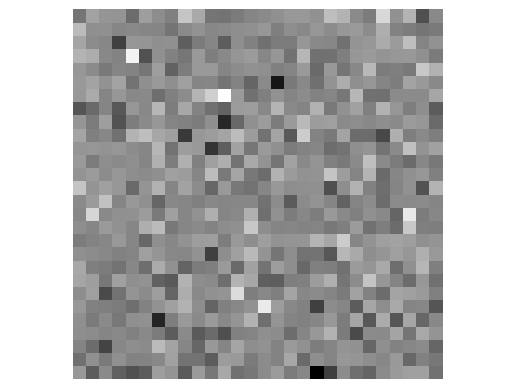

In [107]:
plot_image(no_bounds)

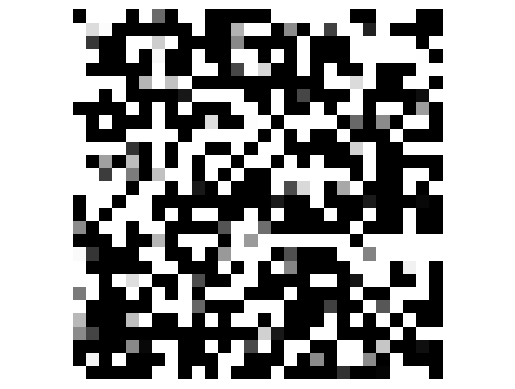

In [109]:
plot_image(with_bounds)

# Original/Truncated/Denoise Image

In [89]:
b=1;m=4;epsilon=5
(ctilde, xtilde, x_pixel)=spread_divergence(c,x,b,m,epsilon,false)
thetaB=zeros(size(x_pixel))
@showprogress for n=1:Ntrain        # speed-up: only find thetaB once
    thetaB[:,n] = prob_xgtx_binomial(x_pixel[:,n],b,m,epsilon)
end

X = convert(Int64,784/b^2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


784

In [90]:
S = 2
MSEs=zeros(S,Ntrain)
MEs=zeros(S,Ntrain)
xsample=zeros(X,S,Ntrain)
for n=1:Ntrain
    for s=1:S
        for l=1:X
            xsample[l,s,n]=rand(Binomial(1,thetaB[l,n]))
        end
        MSEs[s,n]=MSE(x[:,n],xsample[:,s,n])
        MEs[s,n]=ME(x[:,n],xsample[:,s,n])
    end          
end
println("Average MSE between original images and sample denoised images is ", mean(MSEs))
println("Average ME between original images and sample denoised images is ", mean(MEs))



Average MSE between original images and sample denoised images is 0.17130398600725696
Average ME between original images and sample denoised images is 0.1886617405295452


In [91]:
MSEs=zeros(Ntrain)
MEs=zeros(Ntrain)
for n=1:Ntrain
    MSEs[n]=MSE(x[:,n],truncate(xtilde[:,n]))
    MEs[n]=ME(x[:,n],truncate(xtilde[:,n]))
end


println("Average MSE between original images and truncated noised images is ", mean(MSEs))
println("Average ME between original images and truncated noised images is ", mean(MEs))

Average MSE between original images and truncated noised images is 0.2231198904247923
Average ME between original images and truncated noised images is 0.29157508951562106


In [93]:
counter1=0
for n=1:784
    if xsample[n,2,1]==1
        counter1+=1
    end
end
counter1

110

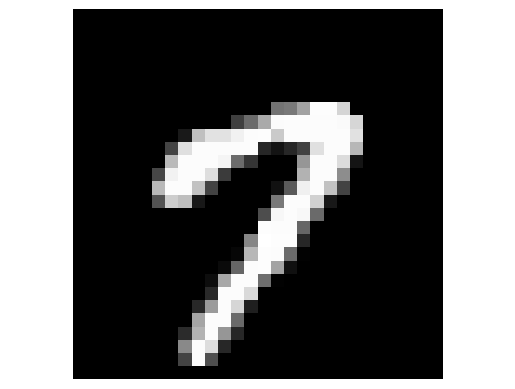

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = plot_image(::Array{Float64,1}) at In[88]:11
└ @ Main .\In[88]:11


In [94]:
plot_image(x[:,n])

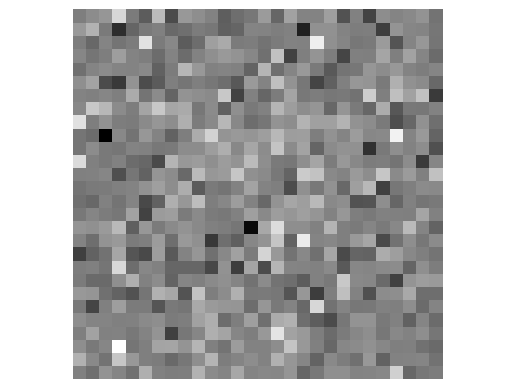

In [95]:
plot_image(xtilde[:,n])

## Truncated Images

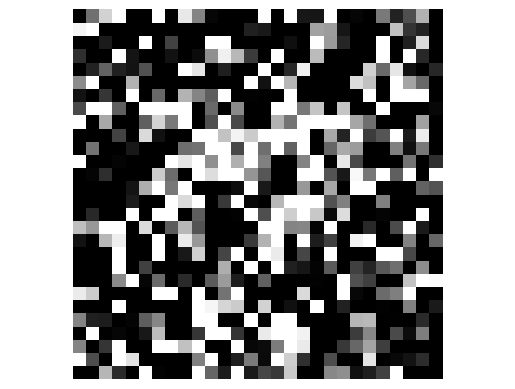

In [96]:
plot_image(truncate(xtilde[:,n]))

## Sample Images

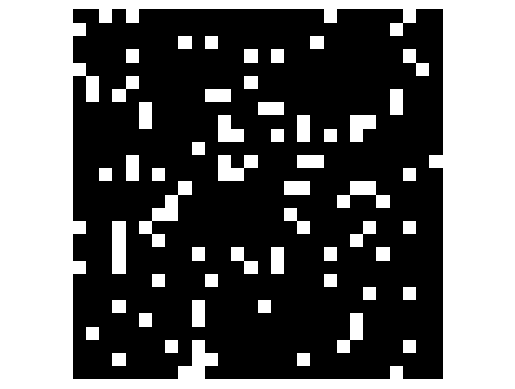

In [97]:
plot_image(xsample[:,1,1])

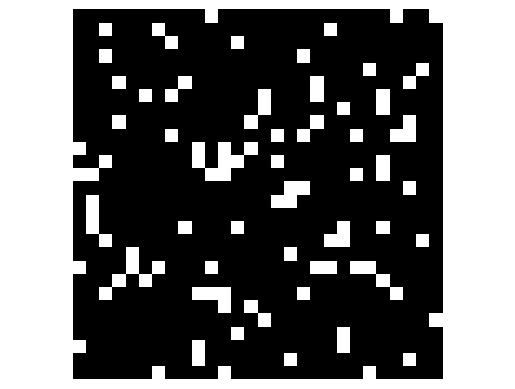

In [98]:
plot_image(xsample[:,2,2])